In [391]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import seaborn as sns

## Functions

### Read Data

In [392]:
def read_data(file_path):
    '''Read Excel File'''
    
    df = pd.read_excel(file_path, engine = 'openpyxl')

    return df

### Prep and Extract Speific Data for time analysis

In [394]:
def prep_total_time_data(df):
    '''Extract relevant data for total time analysis and create new df'''
   
    exam_time_df = df.groupby('candidate_id', as_index=False).first()[
    ['candidate_id', 'exam_start_time', 'last_modified_time', 'extra_time_mins', 'incident_time_mins', 'total_score']
    ]

    return exam_time_df

### Remove Extra and Incident Time from Last modified time

In [397]:
def remove_extra_time(df):
    '''Remove extra and incident time from last_modified_time '''
    df['last_modified_time_without_extra_time'] = (
    df['last_modified_time']
    - pd.to_timedelta(df['extra_time_mins'], unit='m')
    - pd.to_timedelta(df['incident_time_mins'], unit='m')
    )
    return df

### Calculate time usage with extra and incident time

In [398]:
def calc_time_usage_stats_with_extra(df, max_minutes = 210):
    """
    Calculate and adds time usage columns to the DataFrame (df):
      - Brukt_tid: total time used in minutes
      - Tid_igjen: remaining time in minutes
      - Prosent_brukt: percent of allowed time used
    """
    df = df.copy() 
    
    # Calculate how much time was used (in minutes), rounded to 2 decimal places

    df["Total_time_used_mins"] = round((df['last_modified_time'] - df['exam_start_time']).dt.total_seconds() / 60 ,2)

    # Calculate how much time was left (maximum allowed minus used), rounded to 2 decimals 
    df["Remaining_time_mins"] = round(max_minutes - df["Total_time_used_mins"], 2)

    # Calculate percentage of allowed time used, rounded to 2 decimals
    df["%Time_used"] = round((df["Total_time_used_mins"] / max_minutes) * 100, 2)

    
    return df

### Calculate time usage without extra and incident time

In [399]:
def calc_time_usage_stats_without_extra(df, max_minutes = 210):
    """
    Calculate and adds time usage columns to the DataFrame (df):
      - Brukt_tid: total time used in minutes
      - Tid_igjen: remaining time in minutes
      - Prosent_brukt: percent of allowed time used
    """
    df = df.copy() 

    # remove extra time which added automatically to last modified time
    df = remove_extra_time(df)
    # Calculate how much time was used (in minutes), rounded to 2 decimal places
     
    df["Total_time_used_mins_without_extra"] = round((df['last_modified_time_without_extra_time'] - df['exam_start_time']).dt.total_seconds() / 60 ,2)

    # Calculate how much time was left (maximum allowed minus used), rounded to 2 decimals 
    df["Remaining_time_mins_without_extra"] = round(max_minutes - df["Total_time_used_mins_without_extra"], 2)

    # Calculate percentage of allowed time used, rounded to 2 decimals
    df["%Time_used_without_extra"] = round((df["Total_time_used_mins_without_extra"] / max_minutes) * 100, 2)

    
    return df

### Calculate statistic for boxplotting with extra and incident time

In [400]:
def calculate_stats_with_extra_time(df):
    ''' calulate statsitc value for boxplot'''
    q1 = df['Total_time_used_mins'].quantile(0.25)
    q2 = df['Total_time_used_mins'].quantile(0.5)  # median
    q3 = df['Total_time_used_mins'].quantile(0.75)
    iqr = q3 - q1
    
    # remove outliers from plotbox and stats
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # detect outliers
    outliers = df[
    (df['Total_time_used_mins'] < lower_bound) |
    (df['Total_time_used_mins'] > upper_bound)
    ]

    # remove outliers
    clean_df = df[
    (df['Total_time_used_mins'] >= lower_bound) &
    (df['Total_time_used_mins'] <= upper_bound)
    ]

    print(f"Outliers removed:\n{outliers[['candidate_id', 'Total_time_used_mins']]}")

    #calc mean and median
    mean = df['Total_time_used_mins'].mean()
    median = df['Total_time_used_mins'].median()
    

    return q1, q2, q3, mean, iqr, clean_df


### Calculate statistic for boxplotting without extra and incident time

In [401]:
def calculate_stats_without_extra_time(df):
    ''' calulate statsitc value for boxplot'''
    
    q1 = df['Total_time_used_mins_without_extra'].quantile(0.25)
    q2 = df['Total_time_used_mins_without_extra'].quantile(0.5)  # median
    q3 = df['Total_time_used_mins_without_extra'].quantile(0.75)
    iqr = q3 - q1
    
    # remove outliers from plotbox and stats
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # detect outliter
    outliers = df[
    (df['Total_time_used_mins_without_extra'] < lower_bound) |
    (df['Total_time_used_mins_without_extra'] > upper_bound)
    ]

    # remove outlier
    clean_df = df[
    (df['Total_time_used_mins_without_extra'] >= lower_bound) &
    (df['Total_time_used_mins_without_extra'] <= upper_bound)
    ]

    print(f"Outliers removed:\n{outliers[['candidate_id', 'Total_time_used_mins_without_extra']]}")
 
    #calc mean and median
    mean = df['Total_time_used_mins_without_extra'].mean()
    median = df['Total_time_used_mins_without_extra'].median()
    

    return q1, q2, q3, mean, iqr, clean_df

    

### Boxplotting with extra and incident time

In [403]:
def plot_exam_time_boxplot(q1, q2, q3, mean, iqr, df):
    ''' Make box plot of time data'''


    plt.figure(figsize=(8,6))  # narrower figure
    sns.boxplot(y=df['Total_time_used_mins'], color='lightblue', width=0.3)
    plt.ylabel('Total Time Used (mins)')
    plt.title('Distribution of Total Exam Time Used With Extra Time')
    plt.grid(True)
    plt.tight_layout()


    # Adjust x-axis limits to center boxplot
    plt.xlim(-0.5, 0.5)

    # Horizontal lines for median and mean
    plt.hlines(y=q2, xmin=-0.15, xmax=0.15, color='green', linestyle='--', linewidth=1)
    plt.hlines(y=mean_, xmin=-0.15, xmax=0.15, color='red', linestyle='-.', linewidth=1.5)

    # Create legend handles for lines with labels and values
    median_handle = mlines.Line2D([], [], color='green', linestyle='--', linewidth=1, label=f"Median (Q2): {q2:.2f}")
    mean_handle = mlines.Line2D([], [], color='red', linestyle='-.', linewidth=1.5, label=f"Mean: {mean_:.2f}")

    # Add text-only entry for Q1, Q3, IQR
    stats_text = f"Q1: {q1:.2f} \n Q3: {q3:.2f}  \n IQR: {iqr:.2f}"
    stats_patch = mpatches.Patch(color='none', label=stats_text)

    plt.legend(handles=[median_handle, mean_handle, stats_patch], loc='upper right', fontsize=10, frameon=True)
    plt.show()

### Boxplotting without extra and incident time

In [404]:
def plot_exam_time_boxplot2(q1, q2, q3, mean, iqr, df):
    ''' Make box plot of time data'''


    plt.figure(figsize=(8,6))  # narrower figure
    sns.boxplot(y=df['Total_time_used_mins_without_extra'], color='lightblue', width=0.3)
    plt.ylabel('Total Time Used (mins)')
    plt.title('Distribution of Total Exam Time Used Without Extra Time')
    plt.grid(True)
    plt.tight_layout()


    # Adjust x-axis limits to center boxplot
    plt.xlim(-0.5, 0.5)

    # Horizontal lines for median and mean
    plt.hlines(y=q2, xmin=-0.15, xmax=0.15, color='green', linestyle='--', linewidth=1)
    plt.hlines(y=mean_, xmin=-0.15, xmax=0.15, color='red', linestyle='-.', linewidth=1.5)

    # Create legend handles for lines with labels and values
    median_handle = mlines.Line2D([], [], color='green', linestyle='--', linewidth=1, label=f"Median (Q2): {q2:.2f}")
    mean_handle = mlines.Line2D([], [], color='red', linestyle='-.', linewidth=1.5, label=f"Mean: {mean_:.2f}")

    # Add text-only entry for Q1, Q3, IQR
    stats_text = f"Q1: {q1:.2f} \n Q3: {q3:.2f}  \n IQR: {iqr:.2f}"
    stats_patch = mpatches.Patch(color='none', label=stats_text)

    plt.legend(handles=[median_handle, mean_handle, stats_patch], loc='upper right', fontsize=10, frameon=True)
    plt.show()

### Exectute Some of Pervious functions all at once

In [405]:
def run_analysis(file_path):

    # Read Data
    df = read_data(file_path)

    # prep and extract data from original df for time per task analysis
    exam_time_df = prep_total_time_data(df)

    # convert time taken per task from second to minutes
    exam_time_df = calc_time_usage_stats_with_extra(exam_time_df, max_minutes = 210)

    exam_time_df = calc_time_usage_stats_without_extra(exam_time_df, max_minutes = 210)


    # calculate ideal time 
   # exam_time_df = calculate_ideal_time_per_task(exam_time_df)

    return exam_time_df


### Expore Data into a file

In [406]:
def export_data(df, output_path, file_format='xlsx'):
    """
    Save cleaned data to file
    Args:
        df (pandas.DataFrame): Cleaned DataFrame
        output_path (str): Path to save the file
        file_format (str): Format to save ('xlsx', 'csv', 'json')
    """
    try:
        if file_format == 'xlsx':
            df.to_excel(output_path, index=False)
        elif file_format == 'csv':
            df.to_csv(output_path, index=False)
        elif file_format == 'json':
            df.to_json(output_path, orient='records', indent=2)
        else:
            raise ValueError(f"Unsupported format: {file_format}")
        
        print(f"Data saved successfully to {output_path}")
    except Exception as e:
        print(f"Error saving data: {e}")

## Execute Analysis

In [422]:
# Read our data file
exam_time_df = run_analysis("data/cleaned_data.xlsx")

In [408]:
export_data(exam_time_df, 'processed data/Total_Exam_Time_Analysis_2024.xlsx', 'xlsx')

Error saving data: [Errno 13] Permission denied: 'processed data/Total_Exam_Time_Analysis_2024.xlsx'


### Calculating States, outliers and boxplotting

Outliers removed:
     candidate_id  Total_time_used_mins
98          17244                 57.28
273         17465                 49.25
411         17639                 40.75


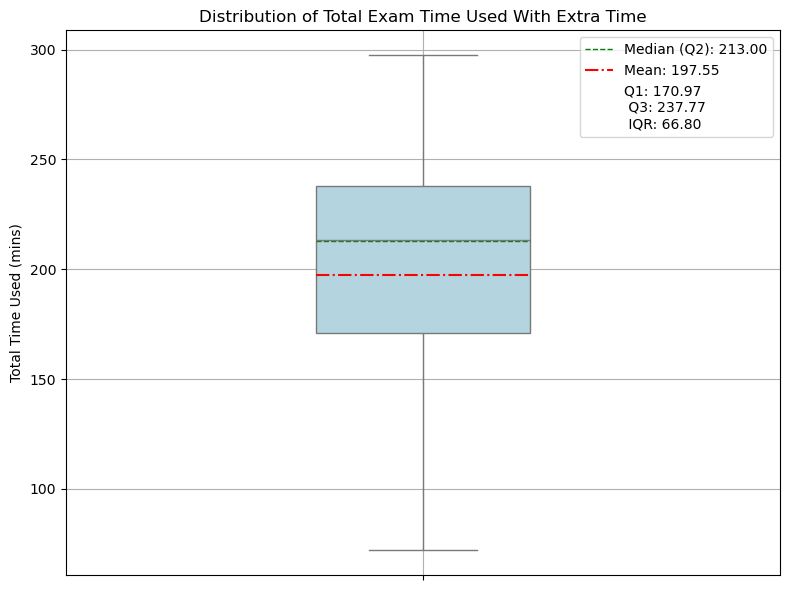

In [409]:
# with extra and incident time
q1, q2, q3, mean, iqr, df_with_extra_time = calculate_stats_with_extra_time(exam_time_df)
plot_exam_time_boxplot(q1, q2, q3, mean, iqr, df_with_extra_time)

Outliers removed:
     candidate_id  Total_time_used_mins_without_extra
98          17244                               57.28
273         17465                               49.25
411         17639                               40.75


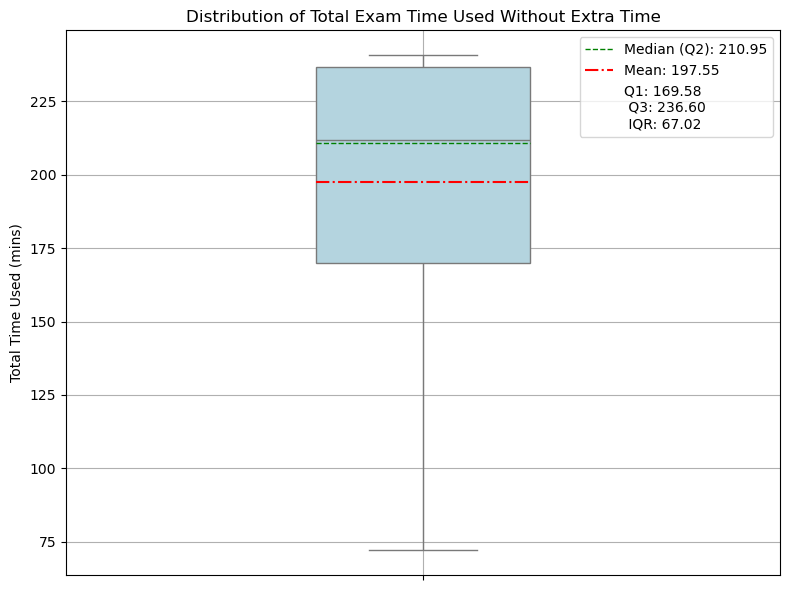

In [410]:
# withour extra and incident time from last modified exam time 
q1, q2, q3, mean, iqr, df_without_extra_time = calculate_stats_without_extra_time(exam_time_df)
plot_exam_time_boxplot2(q1, q2, q3, mean, iqr, df_without_extra_time)